# Chlamydia prevalence in London

This case study will look at a method for estimating chlamydia prevalence in a local area, based on the numbers of tests ordered and diagnoses made. A full description of the methodology, and analysis for the whole of England, can be found in Lewis & White _Epidemiology_ (2017), with code at https://github.com/joanna-lewis/ct_surveillance.

The analysis is carried out in Python, and we will use the `pandas` library and the `lambda` and `fsolve` commands.

## Background

* 3.1% of young women and 2.3% of young men infected with chlamydia (Natsal-3).
* Concern, as infection can lead to pelvic inflammatory disease (PID) and subsequent infertility or ectopic pregnancy.
* Screening (widespread asymptomatic testing) proposed as a control measure, to reduce chlamydia prevalence and the incidence of PID.
* Chlamydia screening in England since 2003; fully implemented by 2008.
* Screening programme collects numbers of tests and diagnoses, but not clear how this corresponds to prevalence.

For example:

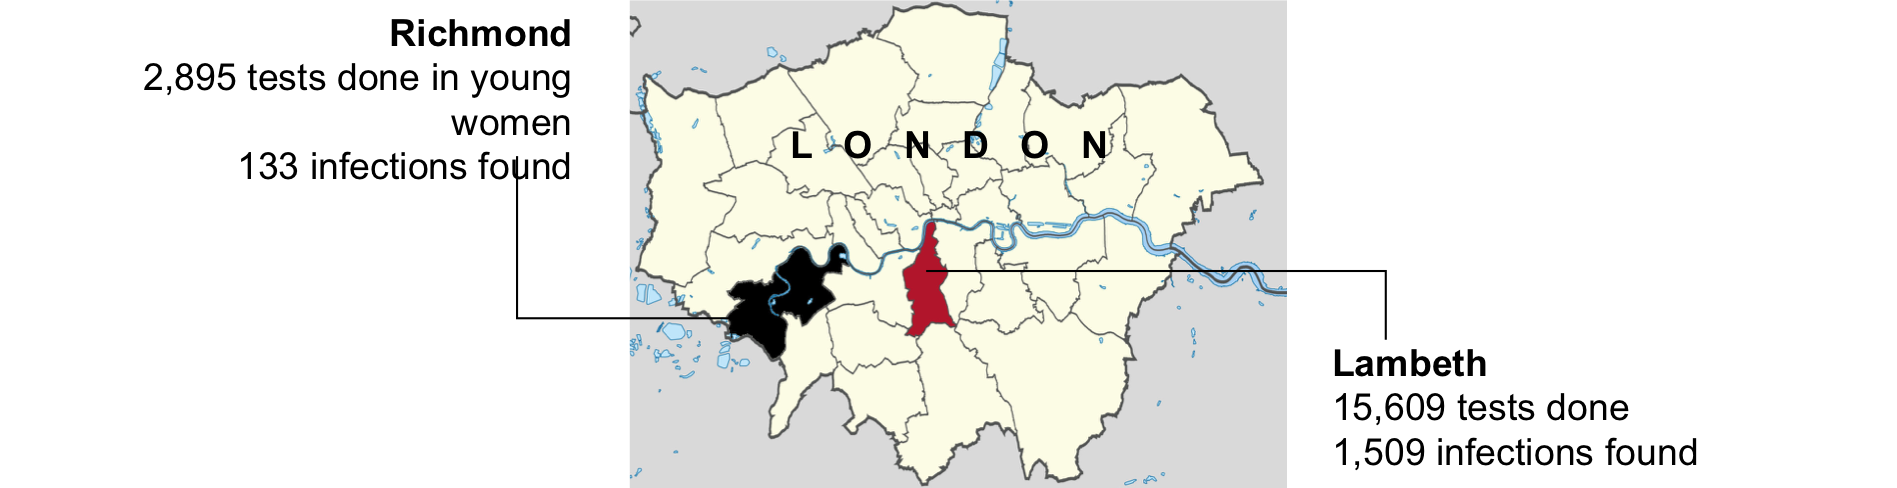

In [1]:
from IPython.display import Image
Image(filename="map.png", width=1000)

So...
* Did we find more cases in Lambeth because women there were more likely to be infected?
* Or was it just because we did more tests?

Our analysis estimates prevalence, based on population size, number of tests and number of diagnoses.

## Reading and handling data

Begin by reading in data using the `pandas` library.

In [ ]:
# import the library
import pandas as pd
from pandas import *

* Read in the data from the file `2012_age_sex_LA.csv`.
* Give it the name `alldata`.
* Set an index which is the row number, starting with 0.

In [ ]:
##########
# your code here
##########

Now retain only the rows in the London PHE region.

In [ ]:
# la: Local Authority (Upper Tier)
# gor: Government Office Region
# pher: Public Health England Region
# phec: Public Health England Centre

# Keep only the London Boroughs
alldata = # your code here

alldata

## Running scripts from within a notebook

We need to run three external python scripts to prepare for the analysis. The first is named `test_diag_fun.py`.

In [ ]:
# This script also contains the functions linking observed tests, symptomatic/asymptomatic/toal diagnoses, 
# incidence, prevalence, screening and other model parameters
# Running it takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

Now run `multinomial_pmf.py` and `sample_parameters.py`.

In [ ]:
# This script provides a function for calculating the likelihood of categorical data.
# your code here

# This script samples model parameters from prior distributions, following the method in england.ipynb.
# your code here

## Now estimate prevalence by London borough

We are going to estimate prevalence using our function `test_diag_fun`, which takes as its input (in this order):
1. Force of infection `inc`
2. Asymptomatic testing rate `scr`
3. Proportion of incident infections which are symptomatic `1 - p_asymp`
4. Rate of natural infection self-clearance `sc`
5. True positive rate of the test  `p_true_pos`
6. False positive rate of the test `p_false_pos`

The function returns:
1. Testing rate
2. Diagnosis rate

Input parameters 3-6 are known from the literature. Testing and diagnosis rates are observed. We provide values for these quantities:

In [ ]:
# First, we'll give Python some values for the model parameters known from the literature:
p_asymp = 0.510
sc = 0.47
trt_seek = 14.4
p_true_pos = 0.971
p_false_pos = 0.00314

# Let's say we have observed 566908 tests and 48387 diagnoses in a year, in a population of 3519015.
test_rate = 566908. / 3519015.
diag_rate = 48387. / 3519015.

We want to work out the force of infection and the asymptomatic testing rate by solving the equation:

    test_diag_fun(force of infection, asymptomatic testing rate, <other parameters>) 
    = (testing rate, diagnosis rate)

We will use an anonymous (`lambda`) function.

Write an anonymous function that takes (force of infection, screening rate) as its input and returns (test rate, diagnosis rate).

In [ ]:
##########
# your code here
##########

Now use the anonymous function with `fsolve` to work out the force of infection and screening rate that correspond to the observed testing and diagnosis rates. (You can find the `fsolve` manual here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html.)

In [ ]:
[inc, scr] = # your code here

print 'Force of infection:', inc
print 'Asymptomatic testing rate:', scr

We can then use the function `dyn_fun` to calculate prevalence from our force of infection and asymptomatic testing.

In [ ]:
# local prevalence, calculated from local screening and incidence
prev = dyn_fun(
    inc*p_asymp, 
    sc + scr*p_true_pos, 
    inc*(1-p_asymp), 
    scr*p_true_pos + trt_seek*p_true_pos
    )

print 'Prevalence:', prev

There is some uncertainty in the natural history parameters in our model, which we will account for by drawing multiple samples for each parameter and calculating the corresponding prevalence each time.

We've already run a script to sample the natural history parameters. Now we sample for testing and diagnosis rates:

In [ ]:
# NB random state (rs) is set in sample_parameters.py, above.

# set up arrays to store, for each LA: 
test_sample_m = empty([n_sample, len(alldata)]) # testing rate
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_m = empty([n_sample, len(alldata)]) # observed diagnosis rate
diag_sample_f = empty([n_sample, len(alldata)])
diag_m_la = empty([n_sample, len(alldata)]) # predicted diagnosis rate
diag_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    #####
    # men
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_m[:,i] = rs.gamma(alldata['tests.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    diag_sample_m[:,i] = rs.gamma(alldata['positives.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
        
    #####
    # women
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = rs.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = rs.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)



Now, write a `for` loop using your `lambda` function and `fsolve`, to calculate the prevalence in men and women, for each sample, in each London Borough.

In [ ]:
# set up arrays to store, for each LA: 
scr_m_la = empty([n_sample, len(alldata)]) # screening (estimated for each LA separately)
scr_f_la = empty([n_sample, len(alldata)])
inc_m_la = empty([n_sample, len(alldata)])  # estimated incidence
inc_f_la = empty([n_sample, len(alldata)])
prev_m_la = empty([n_sample, len(alldata)]) # estimated prevalence
prev_f_la = empty([n_sample, len(alldata)])

##########
# your code here
##########


## And now.. lots of plots!

We now reproduce some of the plots from the _Epidemiology_ paper.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Define a function to represent a large number of samples using error bars.
def plt_ppc(ax, xsample, ysample, index, ci, col, alpha=1): 
    # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50, index), 
                percentile(ysample, 50, index), 
                xerr=squeeze(
                    array([[percentile(xsample,50, index) - percentile(xsample, (100.-ci)/2, index)], 
                           [percentile(xsample, (100.+ci)/2, index) - percentile(xsample,50, index)]])
            ), 
                yerr=squeeze(
                    array([[percentile(ysample,50, index) - percentile(ysample, (100.-ci)/2, index)], 
                           [percentile(ysample, (100.+ci)/2, index) - percentile(ysample,50, index)]])
            ),
                linestyle = 'None', color = col, alpha=alpha)

### Prevalence by borough

We plot the prevalence in each borough individually.

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

order_m = argsort(percentile(prev_m_la,50,axis=0)) # order by prevalence in men
# Comment-out the next line to plot all LAs. You will also need to adjust axis sizes.
#order_m = order_m[append(range(0,5),range(28,33))] 
ax1.errorbar(
    y = range(len(order_m)), 
    x = (percentile(prev_m_la,50,axis=0))[order_m], 
    xerr=array([percentile(prev_m_la[:,order_m],50,axis=0) - percentile(prev_m_la[:,order_m],2.5,axis=0),
            percentile(prev_m_la[:,order_m],97.5,axis=0) - percentile(prev_m_la[:,order_m],50,axis=0)]
            ), 
    fmt='.')

ax1.set_ylim(-1, len(order_m)); ax1.set_xlim(0, 0.17)
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.grid(True)
ax1.set_yticklabels([])

print 'Lowest prevalence in men (median sample):', (percentile(prev_m_la,50,axis=0))[order_m[0]]
print 'Highest prevalence in men (median sample):', (percentile(prev_m_la,50,axis=0))[order_m[-1]]

order_f = argsort(percentile(prev_f_la,50,axis=0)) # order by prevalence in women
# Comment-out the next line to plot all LAs. You will also need to adjust axis sizes.
#order_f = order_f[append(range(0,5),range(28,33))] 
ax2.errorbar(
    y = range(len(order_f)), 
    x = (percentile(prev_f_la,50,axis=0))[order_f], 
    xerr=array([percentile(prev_f_la[:,order_f],50,axis=0) - percentile(prev_f_la[:,order_f],2.5,axis=0),
            percentile(prev_f_la[:,order_f],97.5,axis=0) - percentile(prev_f_la[:,order_f],50,axis=0)]
            ), 
    color='r',fmt='.')  

for i in xrange(33):
    ax1.text(0.09, i, alldata.la[order_m[i]], va='center')
    ax2.text(0.09, i, alldata.la[order_f[i]], va='center')

ax2.set_ylim(-1, len(order_f)); ax2.set_xlim(0, 0.17)
ax2.set_xlabel('Prevalence in sexually active women 15-24')
ax2.grid(True)
ax2.set_yticklabels([])

print 'Lowest prevalence in women (median sample):', (percentile(prev_f_la,50,axis=0))[order_f[0]]
print 'Highest prevalence in women (median sample):', (percentile(prev_f_la,50,axis=0))[order_f[-1]]


Although there is clear evidence of a difference between the highest- and lowest-prevalence boroughs, most of those in between have similar levels of infection.

### Positivity and prevalence

The next figure illustrates the relationship between positivity (proportion of tests that return a positive result) and prevalence.

In [ ]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# positivity
pos_m_la = diag_sample_m/test_sample_m
pos_f_la = diag_sample_f/test_sample_f

# add to plot
plt_ppc(ax1, prev_m_la, pos_m_la, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(prev_m_la, 50, 0), percentile(pos_m_la, 50, 0), '.b')
plt_ppc(ax2, prev_f_la, pos_f_la, 0, 95, 'r', alpha=0.2)
ax2.plot(percentile(prev_f_la, 50, 0), percentile(pos_f_la, 50, 0), '.r')

ax1.set_xlim([0,0.08]); ax1.set_ylim([0,0.2])
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.set_ylabel('Positivity')
#ax1.set_title('Sexually active men 15-24')
ax2.set_xlim([0,0.08]); ax2.set_ylim([0,0.2])
ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')


Although positivity is correlated with prevalence, they are not equal and there are many pairs where a borough with a higher positivity has a lower prevalence.

### Prevalence and deprivation

Next, we investigate the relationship between a borough's prevalence and index of multiple deprivation.

In [ ]:
# lookup table for local authority coding in NCSP vs deprivation data
# Contains National Statistics data © Crown copyright and database right 2016
district_key = pd.read_csv('LAD12_CTY12_EN_LU.csv')

# indices of deprivation downloaded from 
# https://www.gov.uk/government/statistics/english-indices-of-deprivation-2010 1 December 2010
# Contains public sector information licensed under the Open Government Licence v3.0; 
# http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/

# code equivalents downloaded from 
# https://data.gov.uk/dataset/local-authority-districts-uk-2012-names-and-codes 4 January 2016
code_key = pd.read_csv('code_equivalents.csv') 
deprivation = pd.read_csv('deprivation_indices_2010.csv') 

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

quantiles_m = percentile(prev_m_la, [50,2.5,97.5], 0)
quantiles_f = percentile(prev_f_la, [50,2.5,97.5], 0)

for i in deprivation.index:
    
    old_code = deprivation[u'LA CODE'][i]
    new_code = code_key['Current code'][code_key['Former code'] == old_code].tolist()[0]
    
    # special case for Northumberland, because a new code was allocated when boundaries changed:
    if new_code == 'E06000048': # Northumberland
        new_code = 'E06000057'
    
    if new_code in alldata.la_code.tolist(): # if LA can be found in NCSP data using new code
        ax1.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.la_code == new_code)],
                '.b')
        ax1.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_m[0]-quantiles_m[1])[where(alldata.la_code == new_code)],
                             (quantiles_m[2]-quantiles_m[0])[where(alldata.la_code == new_code)]]),
                color='b', alpha=0.2)
        ax2.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.la_code == new_code)],
                '.r')
        ax2.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_f[0]-quantiles_f[1])[where(alldata.la_code == new_code)],
                             (quantiles_f[2]-quantiles_f[0])[where(alldata.la_code == new_code)]]),
                color='r', alpha=0.2)
    
ax1.set_xlim([0,350]); ax1.set_ylim([0,0.07])
ax1.set_xlabel('Index of Multiple Deprivation')
ax1.set_ylabel('Prevalence in sexually active 15-24-year-olds')
#ax1.set_title('Sexually active men 15-24 years')
ax2.set_xlim([0,350]); ax2.set_ylim([0,0.07])
ax2.set_xlabel('Index of Multiple Deprivation')
#ax2.set_ylabel('Prevalence')
#ax2.set_title('Sexually active women 15-24 years')


### Mapping

Finally, we plot prevalence on a map, with boroughs coloured to show their prevalence quintile.

In [ ]:
import shapefile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sf = shapefile.Reader(
    "County_and_unitary_authorities_E+W_2013_Boundaries_Generalised_Clipped/CTYUA_DEC_2013_EW_BGC"
    )
recs    = sf.records()
shapes  = sf.shapes()

blues = plt.get_cmap('Blues')  # this returns a colormap
reds = plt.get_cmap('Reds')  # this returns a colormap

key_ys = array([2.02, 2.07, 2.12, 2.17, 2.22])*10**5 # y-co-ordinates for key
key_labels = ['lowest quintile','2nd quintile','3rd quintile','4th quintile','highest prevalence quintile']

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

n_quantile = 5 # how many different colours do you want to plot?

def tickpar(ax):
    ax.tick_params(
        axis='both', # changes apply to 
        which='both', # both major and minor ticks are affected
        bottom='off', # ticks along the bottom edge are off
        top='off', # ticks along the top edge are off
        left='off',      
        right='off',         
        labelbottom='off',
        labelleft='off') # labels along the left edge are off
    
#######################
# plot prevalence in men
#######################

cNorm  = plt.Normalize(vmin=0, vmax=n_quantile)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=blues)
colors = argsort(percentile(prev_m_la,50,0))
ranks = argsort(colors)

for nshp in alldata.index:
    
   
    # code for this LA
    thiscode = alldata.la_code[nshp]
    # index to find the right shape file for this la:
    shpin = where( map(lambda x: thiscode == x, [recs[i][0] for i in range(len(recs))]) ) 
    shpin = int(shpin[0])
    
    ptchs   = []
    pts     = array(shapes[shpin].points)
    prt     = shapes[shpin].parts
    par     = list(prt) + [pts.shape[0]]
    
    colorVal = scalarMap.to_rgba(n_quantile*ranks[nshp]/32)
    
    for pij in xrange(len(prt)):
        ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
        
        p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
        p.set_clim([0,151])
        ax1.add_collection(p)

# add a key
for i in xrange(5):
    ax1.add_patch(patches.Rectangle((0.502*10**6, key_ys[i]), 0.25*10**4, 0.25*10**4, fc=blues(0.2*i)))
    ax1.text(0.507*10**6, key_ys[i], key_labels[i])

ax1.set_xlim(0.5*10**6, 0.565*10**6)
ax1.set_ylim(1.65*10**5, 2.15*10**5)
ax1.set_aspect('equal', 'datalim')
tickpar(ax1)
p = PatchCollection(ptchs, cmap=blues)

#######################
# plot prevalence in women
#######################

cNorm  = plt.Normalize(vmin=0, vmax=n_quantile)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=reds)
colors = argsort(percentile(prev_f_la,50,0))
ranks = argsort(colors)

for nshp in alldata.index:
    
    # code for this LA
    thiscode = alldata.la_code[nshp]
    # index to find the right shape file for this la:
    shpin = where( map(lambda x: thiscode == x, [recs[i][0] for i in range(len(recs))]) ) 
    shpin = int(shpin[0])
    
    ptchs   = []
    ptchs_l   = []
    pts     = array(shapes[shpin].points)
    prt     = shapes[shpin].parts
    par     = list(prt) + [pts.shape[0]]
    
    colorVal = scalarMap.to_rgba(n_quantile*ranks[nshp]/32)
    
    for pij in xrange(len(prt)):
        ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
        
        p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
        p.set_clim([0,151])
        ax2.add_collection(p)

# add a key
for i in xrange(5):
    ax2.add_patch(patches.Rectangle((0.502*10**6, key_ys[i]), 0.25*10**4, 0.25*10**4, fc=reds(0.2*i)))
    ax2.text(0.507*10**6, key_ys[i], key_labels[i])

ax2.set_xlim(0.5*10**6, 0.565*10**6)
ax2.set_ylim(1.65*10**5, 2.15*10**5)
ax2.set_aspect('equal', 'datalim')
tickpar(ax2)
p = PatchCollection(ptchs, cmap=reds)

# Crown Copyright statement required by ONS.
fig.text(0.9,0.1,
    u'Contains National Statistics data \N{COPYRIGHT SIGN} Crown copyright and database right 2016', 
    ha='right', va='top')

